# Exercise session #3 - $k$-NN Classifier 

In this exercise you will implement  the **$k$-Nearest Neighbor classifier ($k$-NN)**. You will also get familiar with
other very important concepts related to machine learning in practice,
including data preprocessing, distance metrics, visualization, and model evaluation.

We have provided general functionality and pointers for you here. Please complete the code with your own implementation below. Please also discuss and answer the follow-up questions.

### 1. Dataset and problem description

The Healthy Body dataset contains body measurements acquired from **1250 people _from different ages, genders, and nationalities_** from different hospitals around the world. Health professionals have performed medical examinations and classified the individuals into three different body categories: **underweight, normal weight, and overweight.**

Our goal is to automate the role of the health professionals i.e, to predict the category of the new data . However, due to anonymity reasons, we have been provided access to limited information about the individuals: their measured _weights_ and _heights_, and their respective _body category_ only.

We will use these features to train a $k$-NN classifier for the task.

---

In [1]:
# Enable interactive plots, so you can zoom/pan/resize plots
%matplotlib notebook

# Libraries for numerical handling and visualization. Install if required
import numpy as np
from matplotlib import pyplot as plt

## 2. Data loading and visualization

The goal of supervised classification algorithms such as $k$-NN is to use information from a set of labeled examples, i.e., examples for which we know their class assignments, to infer the classes for unlabeled examples.

In [2]:
# Data loading

# Paths
features_annotated_path = "hbody_feats_annotated.npy"     # Weights, heights of individuals with known body category
labels_annotated_path = "hbody_labels_annotated.npy"      # Body categories of those individuals
features_unannotated_path = "hbody_feats_unannotated.npy" # Weights and heights of unknown body category individuals
                                                          # - Goal: Figure out their body categories

# Features organized in an NxD matrix; N examples, D features.
# Another way to look at it: each of the N examples is a D-dimensional feature vector.

features_annotated = np.load(features_annotated_path)
features_unannotated = np.load(features_unannotated_path)
labels_annotated = np.load(labels_annotated_path)

class_names = ('Underweight', 'Normal weight', 'Overweight')


**Q. What are the target variables? What are the predictor variables?**  
**A.** Target variables' values are being predicted by our machine learning algorithm. On the other hand, predictor variables values are input to the algorithm. In this particular case, body category is target variable and predictors are body weight and height.

---

<IPython.core.display.Javascript object>


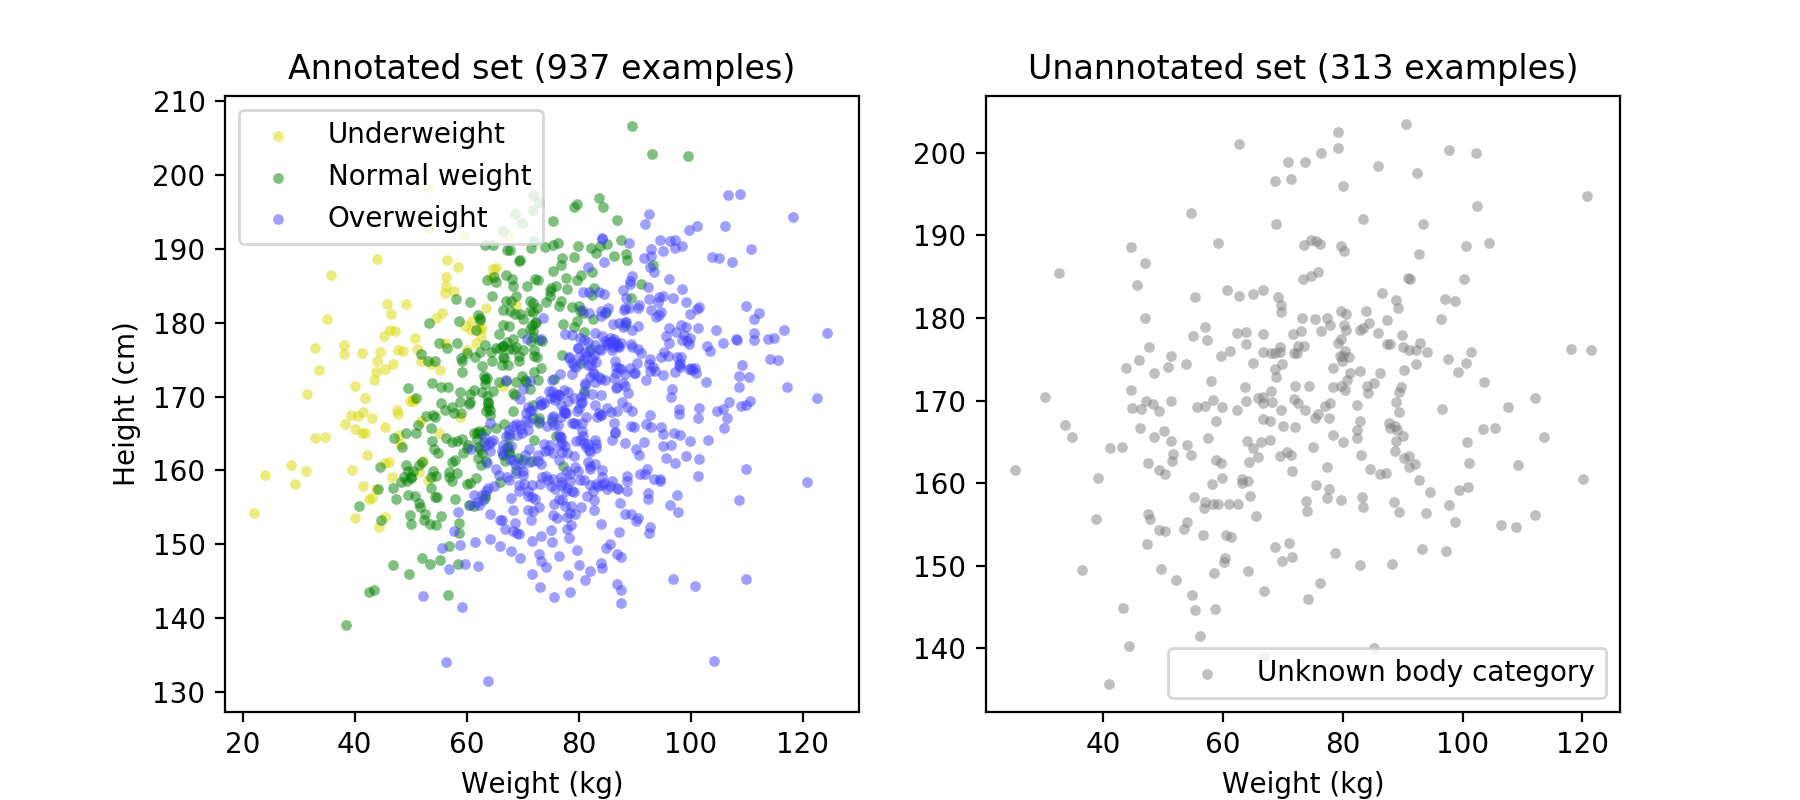

In [3]:
# Visualize annotated and unannotated sets

colors = np.array([[0.85, 0.85, 0], [0, 0.5, 0], [0.25, 0.25, 1]])

plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.title(f"Annotated set ({len(labels_annotated)} examples)")
for i, class_name in enumerate(class_names):
    plt.scatter(*features_annotated[labels_annotated==i].T,
                c=colors[i, None], alpha=0.5, s=15, lw=0, label=class_name)
plt.xlabel("Weight (kg)")
plt.ylabel("Height (cm)")
plt.legend();

plt.subplot(1,2,2)
plt.title(f"Unannotated set ({len(features_unannotated)} examples)")
plt.scatter(*features_unannotated.T, c='gray', alpha=0.5, s=15, lw=0, label='Unknown body category')
plt.xlabel("Weight (kg)")
plt.legend();

**Q. Do you think this is an easy or a difficult classification problem? Why?**  
**A.** Except for amibiguity at the class boundaries, classes are separated from each other and learning separation will be easy or difficult depending on how much mis-classification we would like to allow. 

**Q. What should the unannotated set share in common with the annotated set?**  
**A.** Both should come from similar distribution.

---

### 2.1 Normalizing data

$k$-NN determines neighbors by computing the "distance" between two examples. For this process to work, we are required
to normalize the features. This is true for many other machine learning algorithms as well.

**Q. What would happen if we don't do this?**  
**A.** Different features will have different range of values. For example if we have a feature corresponding to salary of a person vs his/her weight. The salary will be in order of 10^5 and weight will be less than 10^2, which means while computing distances between two data points, salary will be overpower in computation. The iterative algorithms might take time to converge without proper normalization.

A very common way to normalize the data is by the so-called z-score standardization. It transforms values from an arbitrary range such that the result has mean $0$ and standard deviation $1$. The operation is defined as follows:

$$
x_{norm} = \frac {x - \mu_x} {\sigma_x},
$$
for _each feature independently_.



In [4]:
# Normalize the data.
# Tip: Use numpy's broadcasting to write your normalization function

def normalize(features, means, stds):
    # WRITE YOUR CODE HERE
    # return the normalized features
    return (features - means) / stds

# test normalization
dummy_features = np.random.randint(100,size=(10,3))
norm_dummy_features = normalize(dummy_features,dummy_features.mean(0,keepdims=True),dummy_features.std(0,keepdims=True))
if np.allclose(norm_dummy_features.mean(axis=0), 0) and np.allclose(norm_dummy_features.std(axis=0), 1):
    print("Everything alright here.")
else:
    print("Nope. Try again.")

Everything alright here.


## 4. The $k$-Nearest Neighbors Classifier

$k$-NN assigns as label to a given example the most popular label from its surroundings. The method is very intuitive, and can be summarized as:
- Compute the distance between the example to classify and all the training examples.
- Select the closest $k$ training examples.
- Assign to the example the most common label among those neighbors.

### 4.1 Distance metrics

There are many ways to define a distance between two examples. Two very common ones that we will use in this exercise are:

#### Euclidean distance:

$$
m(\mathbf{v}, \mathbf{w}) = \sqrt{ \sum_{i=1}^d \left(\mathbf{v}_i - \mathbf{w}_i\right)^2 }
$$

This is the generalization of the Pythagorean theorem to an arbitrary number of dimensions, and corresponds to our intuitive interpretation of the straight-line distance between two points.

#### Manhattan distance:

$$
m(\mathbf{v}, \mathbf{w}) = \sum_{i=1}^d |\mathbf{v}_i - \mathbf{w}_i|
$$

Aggregates differences in features independently from one another. It is also known as city block distance. One can think of it as the minimum distance one would have to walk between two intersections in a city organized by regular blocks.


**Q. Would you expect to find the same nearest neighbors to a point with both distance metrics?**  
**A.** No!!

In [5]:
# Define a function to compute the euclidean distance between a vector and a collection of vectors (matrix)
# Tip: numpy's broadcasting allows you to write this in a very intuitive and simple way.

# example is a vector and training examples a matrix
def euclidean_dist(example, training_examples):
    # WRITE YOUR CODE HERE
    return np.sqrt(((training_examples - example) ** 2).sum(axis=1))

In [6]:
# Define a function to compute the manhattan distance between a vector and a collection of vectors (matrix)
# Tip: numpy's broadcasting allows you to write this in a very intuitive and simple way.

# example is a vector and training examples a matrix
def manhattan_dist(example, training_examples):
    # WRITE YOUR CODE HERE
    return np.abs(training_examples - example).sum(axis=1)

In [7]:
# Find the indices of the k shortest distances from a list of distances
#Tip: use np.argsort()

def find_k_nearest_neighbors(k, distances):
    # WRITE YOUR CODE HERE
    indices = np.argsort(distances)[:k]
    return indices

# test k nearest neighbors
dummy_distances = [10.,0.5,200,0.006,43,4.5,11.,50]
top_k = 5
top_k_indices = find_k_nearest_neighbors(top_k,dummy_distances)

if np.allclose(top_k_indices,[3,1,5,0,6]):
    print('Implementation is correct')
else:
    print('Oops!! Something is wrong')
        

Implementation is correct


In [8]:
# Given a list of neighbor labels, choose the most frequent one.
# Tip: np.bincount and np.argmax are your friend.

def predict_label(neighbor_labels):
    # WRITE YOUR CODE HERE
    return np.argmax(np.bincount(neighbor_labels))

# test label prediction
dummy_labels = [10,3,2,10,2,2,2,10,10,11,1,2]
if predict_label(dummy_labels) == 2:
    print('Implementation is correct')
else:
    print('Oops!! Something is wrong')


Implementation is correct


### 4.2 $k$-NN Step by Step for a Single Example
Let's implement the algorithm for one example in this section. **Try out different values of k and observe the changes.**

**Q. What do we use as mean and std to normalize our unknown sample? and Why?**  
**A.** We use training set's mean and std to normalize the unknown/validation/test data. Since we assume the statistics of train and validation/test are same, meaning the samples are drawn from same distribution.


In [9]:
# Use the function you just defined to predict the label of a example

# Choosing a random training example and treating as we don't know it's true label. 
total_samples = features_annotated.shape[0]
dummy_unknown = np.random.choice(np.arange(total_samples),1)[0]
all_indices = np.arange(total_samples)
known_label = np.delete(all_indices,dummy_unknown)

# Get the features corresponding to known and unknown points
train_labels = labels_annotated[known_label]
train_feats = features_annotated[known_label,:]
dummy_unknown_feats =  features_annotated[dummy_unknown,:]

# IMPORTANT: Normalize the data, what should be the mean and std? 
# mean_val dimension should be 1x2
# std_val dimension should be 1x2

# WRITE YOUR CODE HERE
mean_val = train_feats.mean(0,keepdims=True)
std_val = train_feats.std(0,keepdims=True)
norm_train_feats = normalize(train_feats,mean_val,std_val)
norm_dummy_unknown_feats = normalize(dummy_unknown_feats,mean_val,std_val)

# choose number of neighbors
k=6

# find distance w.r.t all training examples
distances = euclidean_dist(norm_dummy_unknown_feats, norm_train_feats)
# find the nearest neighbors
nn_indices = find_k_nearest_neighbors(k, distances)
# find labels of nearest neighbors
neighbor_labels = train_labels[nn_indices] 
# find the best label
best_label = predict_label(neighbor_labels) 

print(f'Predicted label: {class_names[best_label]}')

Predicted label: Overweight


<IPython.core.display.Javascript object>


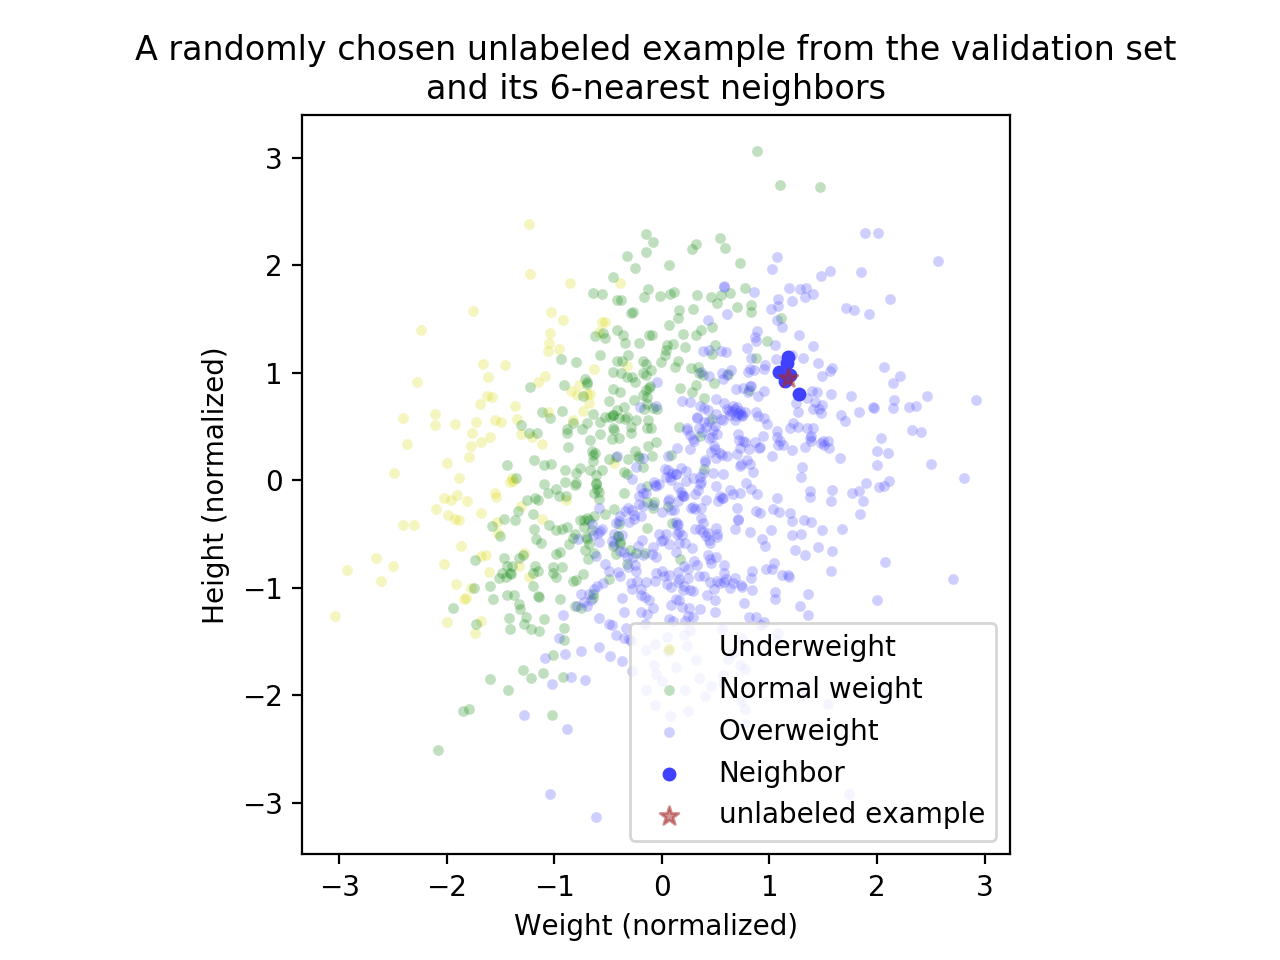

In [10]:
# Visualize the unknown point and its neighbors.
plt.figure()
plt.title(f"A randomly chosen unlabeled example from the validation set\nand its {k}-nearest neighbors")
for i, class_name in enumerate(class_names):
    plt.scatter(*norm_train_feats[train_labels==i].T,
                c=colors[i, None], alpha=0.25, s=15, lw=0, label=class_name)
for i, class_name in enumerate(class_names):
    class_indices = nn_indices[train_labels[nn_indices] == i]
    if len(class_indices) > 0:
        plt.scatter(*norm_train_feats[class_indices].T,
                    c=colors[i, None], alpha=1, s=25, lw=0, label='Neighbor')

ax = plt.scatter(*norm_dummy_unknown_feats[0], marker='*', c='brown', alpha=0.5, s=50, label='unlabeled example')
plt.xlabel("Weight (normalized)")
plt.ylabel("Height (normalized)")
plt.gca().set_aspect('equal')
plt.legend();

### 4.3 Putting things together

In [11]:
# Write a function kNN_one_example that applies all the previous steps
# to predict the label of one example.

def kNN_one_example(unlabeled_example, training_features, training_labels, k):
    # WRITE YOUR CODE HERE
    distances = euclidean_dist(unlabeled_example, training_features)  # Compute distances
    nn_indices = find_k_nearest_neighbors(k, distances)               # Find neighbors
    neighbor_labels = training_labels[nn_indices]                     # Get neighbors' labels
    best_label = predict_label(neighbor_labels)                       # Pick the most common
    
    return best_label

In [12]:
# Write a function kNN that applies kNN_one_example to an arbitrary number of examples.
# Tip: numpy's apply_along_axis does most of the work for you.

def kNN(unlabeled, training_features, training_labels, k):
    # WRITE YOUR CODE HERE
    return np.apply_along_axis(kNN_one_example, 1, unlabeled, training_features, training_labels, k)

**Q. While the above implementation works, it has some drawbacks. Can you identify them?**  
**A.** Since we are calculating distance of a point w.r.t all the other points, we will have duplicate computations since d(a,b) = d(b,a) for most of the distance metrics(d) for points(a,b). Additionally, data points are ordered in space and when using distance metric like Euclidean, one have an ordering property. If a point A is further away from B than C, then a new point D, if further away from A then it is also further away from B. Hence, one can skip  distance calculation with w.r.t D and B, leading to lesser computations. 

**Q. Can you think of a better implementation?**  
**A.** For the first issue, when d(a,b)=d(b,a), we should compute value for a pair only once. In order, to handle second issue, better data structures can be used to store points like [KD-Trees](https://www.analyticsvidhya.com/blog/2017/11/information-retrieval-using-kdtree/)

## 5 Cross Validation

### 5.1 Splitting the annotated data into training, validation, and test sets

We need to ensure that our method generalizes, which means it will correctly predict the class for new provided examples.

In order to simulate this scenario, we will split our annotated data into two groups: the training set, and the test set.
- The **training set** will be used for finding a set of parameters and hyperparameters minimizing a given criterion.
- The **test set** will be used for testing how well the learned model generalizes to data beyond that used for training.

While the training set helps us find out how exactly to manipulate our data to find the right prediction, the test set tells us how well we expect to perform when given new data. Our training procedure is allowed to handle data from the training set only, and should not in any way use the information from the test set.

In [13]:
# Split labeled data into training and test set

# Choose a fixed seed to reproduce same results
np.random.seed(330)

num_annotated_labels = len(labels_annotated)

# percentage of annotated data for train and test sets.
training_perc, test_perc = 0.8, 0.2

indices = np.arange(len(labels_annotated))
np.random.shuffle(indices)

num_train_samples = int(training_perc*num_annotated_labels)
num_test_samples = num_annotated_labels-num_train_samples

# split indices into train and test folds
training_indices, test_indices = np.split(indices,indices_or_sections=[num_train_samples])

# Get the training and test data and labels
training_features = features_annotated[training_indices]
training_labels = labels_annotated[training_indices]
test_features = features_annotated[test_indices]
test_labels = labels_annotated[test_indices]

In [14]:
# Normalize the features to have mean 0 and std 1
# WRITE YOUR CODE HERE
mean_features = training_features.mean(axis=0)
std_features = training_features.std(axis=0)

norm_train_features = normalize(training_features,mean_features,std_features)
norm_test_features = normalize(test_features,mean_features,std_features)


### 5.2 K-Fold Cross-validation

If we are only allowed to assess our model generalization _after_ training, how can we monitor and guide the training process? How can we know beforehand that we are using the best version of our model?

The most common strategy for this, called **[cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics))**, is, simply put, to pretend that a part of our training data is in fact unannotated, and see if our method manages to predict the annotations correctly. In other words, we will reserve a portion of our training data to temporarily act as a small test set. 

Cross Validation(CV) technique is used to choose the best parameters for separate validation set, where the hope is that this set will be close to the (unseen) test set. We train our model on train set and use hyperparameters which give best results on validation set. This is a general technique to choose your best machine learning model.

K-fold is a type of CV technique that we'll see here. We'll split data in K parts and use kth part for validation, whereas k-1 for training. This process will be repeated K times. Metric used to evaluate the model is accuracy on the validation set.

Splitting your training data into a training and a validation set is also used for comparing different "versions" of your model. Many machine learning methods depend on predefined configuration settings, called _hyperparameters_, that heavily influence how the method behaves. In the case of $k$-NN, one such parameter is $k$, the number of neighbors.

In this exercise, we will be applying k-fold cross validation. Technically, your validation set is part of your training data. To avoid confusion, however, we often call the _training set_ the portion of your training data used for tuning your method. Therefore, for k-fold cross validation, we  split our annotated data into a training data, and a test set. Further, we split the training data into k-folds from which one fold is used for validation set and rest of the folds as training set. This process is repeated K times and average performance is calculated. We choose the value of hyperparameter which minimises the error on the cross-validations set. 


**Q. What is the difference between validation set and test set?**  
**A.** The validation set is used during the training process, and helps us make decisions about our model. The test set is not used during training, and does not affect training in any way. It is only used when we have tuned our model, to get an idea of how well our model generalizes to unseen data.


In [15]:
# Function to split data indices

# Inputs:
#        num_examples: total samples in the dataset
#        k_fold: number fold of CV
# 
# Output: array of shuffled indices with shape (k_fold, num_examples//k_fold)

def fold_indices(num_examples,k_fold):
    ind = np.arange(num_examples)
    split_size = num_examples//k_fold
     
    k_fold_indices = []

    # WRITE YOUR CODE HERE
    # Generate k_fold set of indices
    k_fold_indices = [ind[k*split_size:(k+1)*split_size] for k in range(k_fold)]
         
    return np.array(k_fold_indices)


**Q. What does `np.random.seed` do? Why is this useful?**  

**A.** `np.random.seed` resets the internal state of the random generator to a defined value. When randomization if required (as is the case here), this makes sure that we will get the same random ordering every time we run our entire program. This way, we can compare with our colleagues, and with previous versions of our code.


### 5.3 Performance metric to know if the  prediction is good?

In order to quantify the performance of our model, we want to obtain a score that tells us how close the predictions were to the expected classification.

The simplest way to do this is to compute the ratio of correctly predicted examples, also known as the accuracy:

$$
\frac 1 N \sum_{n=1}^N \mathbf{1}[\hat{y} = y]
$$
**Q. Do you see any limitation to using accuracy to evaluate your model?**

**A.** We do not care _what_ particular mistakes the model made. One can argue that incorrectly labeling an overweight person as underweight is worse than labeling them as normal weight.
Also, if most people belonged to one class, just predicting that class for the whole population would give a very high accuracy. Plain accuracy does not account for class imbalances

**Q. Can you think of other ways to evaluate your model?**

**A.** There are many. Qualitatively, one could inspect what mistakes the model made, by computing a confusion matrix: a matrix with counts of all the predictions and expected labels. One could improve the accuracy metric by assigning weights to each example related to its class frequency: the more uncommon a class is, the more important it is that the model classifies the example as belonging to such class.
 Find a nice summary and discussion of popular metrics [here][1].

[1]: https://www.quora.com/What-are-some-good-error-metrics-for-multi-class-classification-when-you-have-many-objects-to-classify

**Q. Is accuracy suitable for multiclass classification?**  
**A.** Plain accuracy is not as suitable as other metrics like F-score, Confusion Matrix, Balanced Accuracy Rate or ROC for multiclass classification. 

**Q. What other criteria, aside from accuracy, should one consider when choosing hyperparameters?**  

**A.** One other criterion is model complexity. When possible, one should choose simpler models over more complicated ones. Other criteria include robustness, speed, and scalability. Find more info [here][1].

[1]: https://www.teradata.com/Blogs/Occam%E2%80%99s-razor-and-machine-learning

In [16]:
# Write a function that computes the accuracy between a predicted and the expected labels.
def accuracy(predicted, target):
    # WRITE YOUR CODE HERE
    return np.mean(predicted == target)

In [24]:
# kNN function using kth split as validation set and rest k-1 splits to train model. 

#Inputs:
#   k_fold - kth fold as cross validation split
#   k_fold_ind -  indices of each split of k-fold split
#   X  -  training data
#   Y  - train labels
#   k - number of nearest neighbours for k-NN algorithm

#Outputs:  return the accuracy of validation set

def kNN_CV(k_fold,k_fold_ind,X,Y,k ):
    
    #use kth split for validation
    val_ind = k_fold_ind[k_fold]
    
    # use rest k-1 splits to train
    train_splits = [i for i in range(k_fold_ind.shape[0]) if i is not k_fold]
    train_ind = k_fold_ind[train_splits,:].reshape(-1)
    
    #Get train and val 
    X_train = X[train_ind,:]
    Y_train = Y[train_ind]
    X_val = X[val_ind,:]
    Y_val = Y[val_ind]
    
    
    
    Y_val_pred = kNN(X_val, X_train, Y_train, k)
    
    #get accuracy for val
    acc = accuracy(Y_val_pred, Y_val)
    return acc

### 5.4 Putting it all together

In [25]:
# Perform a 4-fold cross validation on training dataset

k =  4  # number of nearest neighbours for k-NN
k_fold = 4
k_fold_ind = fold_indices(norm_train_features.shape[0],k_fold)
acc = np.zeros(k_fold)
for fold in range(k_fold):
    # Get validation accuracy with kth fold as validation set and rest as training set
    # WRITE YOUR CODE HERE
    acc[fold] = kNN_CV(fold,k_fold_ind,norm_train_features,training_labels, k)
mean_acc = np.mean(acc)

print(f"{k}-NN Classifier predicted correctly  with accuracy of {mean_acc:.2%} on cross-validation set")

4-NN Classifier predicted correctly  with accuracy of 83.82% on cross-validation set



**Q. How should one select the number of folds of the cross-validation set?**  

**A.** There is no hard rule for this. Ideally, our validation set in ev should be representative of the distribution that generates our data. In practice, this is very hard to measure. For situations where the annotated data is scarce, we have to try to find a balance between the amount of data used for training, so that we can learn good predicting rules, and the amount of data used for validation. Other cross-validation schemes help solve this to some extent.
 


### 5.5 Hyperparameter optimization

Did we choose the best $k$?

We can evaluate our model under different values of $k$ to compare them. A simple way to do it is to evaluate our model's predictions for the same validation set when using different values of $k$.


In [26]:
# Call the CV with different k values

def run_cv_for_hyperparam(k_values, k_fold,norm_train_features,training_labels):

    k_fold_ind = fold_indices(norm_train_features.shape[0],k_fold)
    model_performance = []  # Store the computed metrics here
    for k in k_values:
        for fold in range(k_fold):
            # WRITE YOUR CODE HERE
            acc[fold] = kNN_CV(fold,k_fold_ind,norm_train_features,training_labels, k)
        mean_acc = np.mean(acc)
        model_performance.append(mean_acc)
        
    return model_performance


<IPython.core.display.Javascript object>


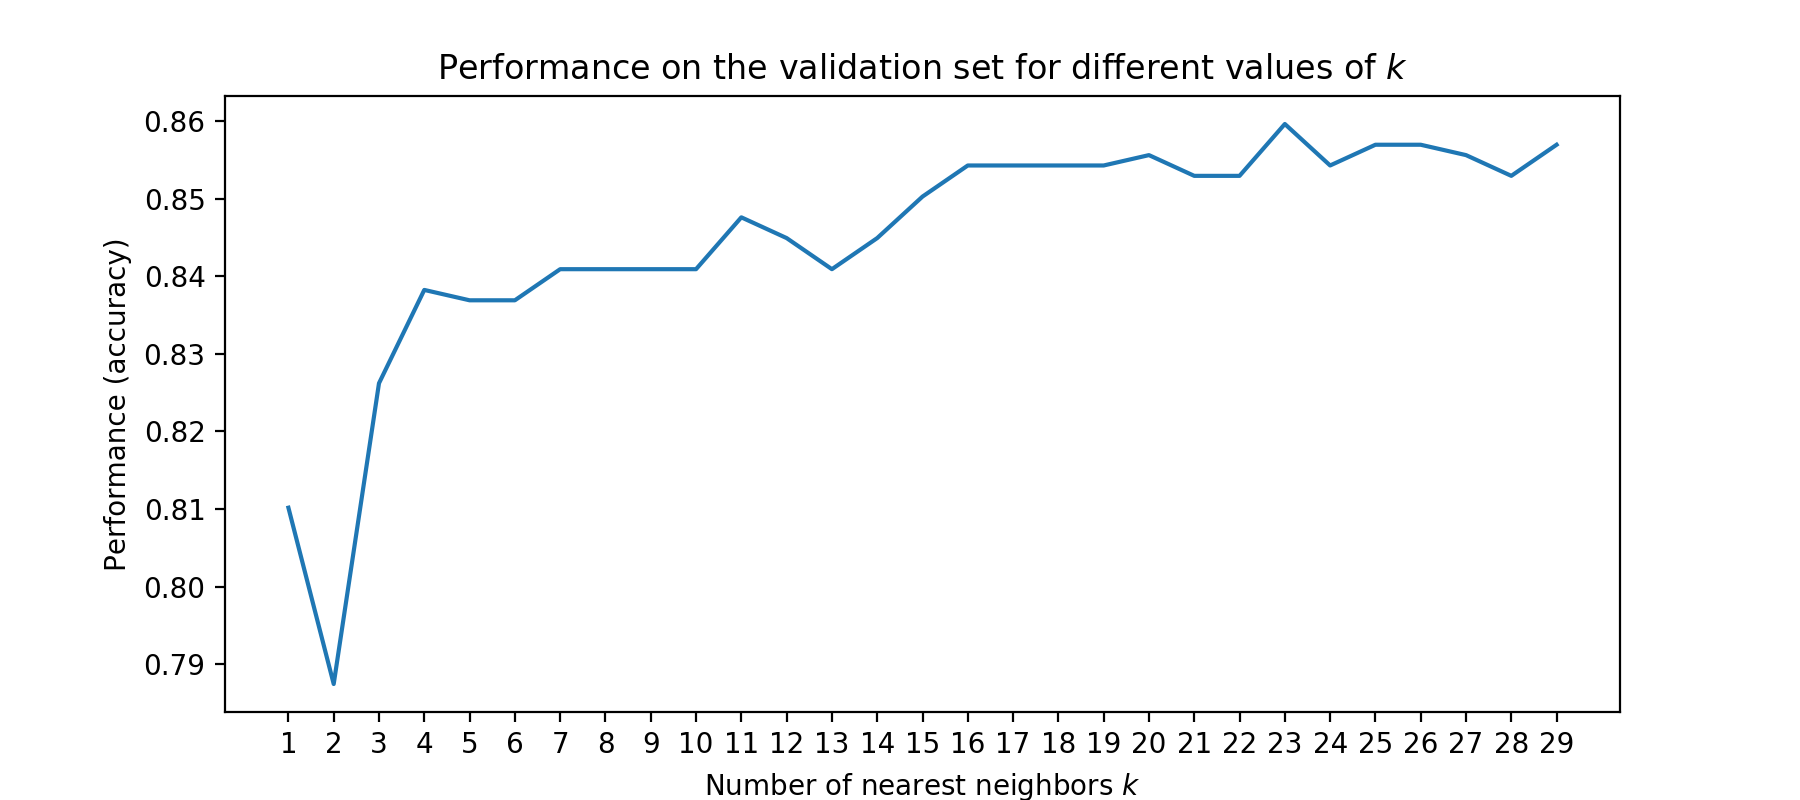

In [27]:
# Visualize the performances for different values of k

k_values = range(1, 30)          # Try these values for hyperparameter k
k_fold = 4
model_performance= run_cv_for_hyperparam(k_values,k_fold,norm_train_features,training_labels)

plt.figure(figsize=(9,4))
plt.title("Performance on the validation set for different values of $k$")
plt.plot(k_values, model_performance)
plt.xlabel("Number of nearest neighbors $k$")
plt.xticks(k_values)
plt.ylabel("Performance (accuracy)");

In [31]:
# Pick hyperparameter value that yields the best performance
# WRITE YOUR CODE HERE
best_k = k_values[np.argmax(model_performance)]

print(f"Best number of nearest neighbors on validation set is k={best_k}")

Best number of nearest neighbors on validation set is k=31


**Q. How do you expect the model to perform with large k values equal to number of training example ?**

**A.** For large values of k, the k-NN classifier predicts the label  same as the most frequent class in the training set.

<IPython.core.display.Javascript object>


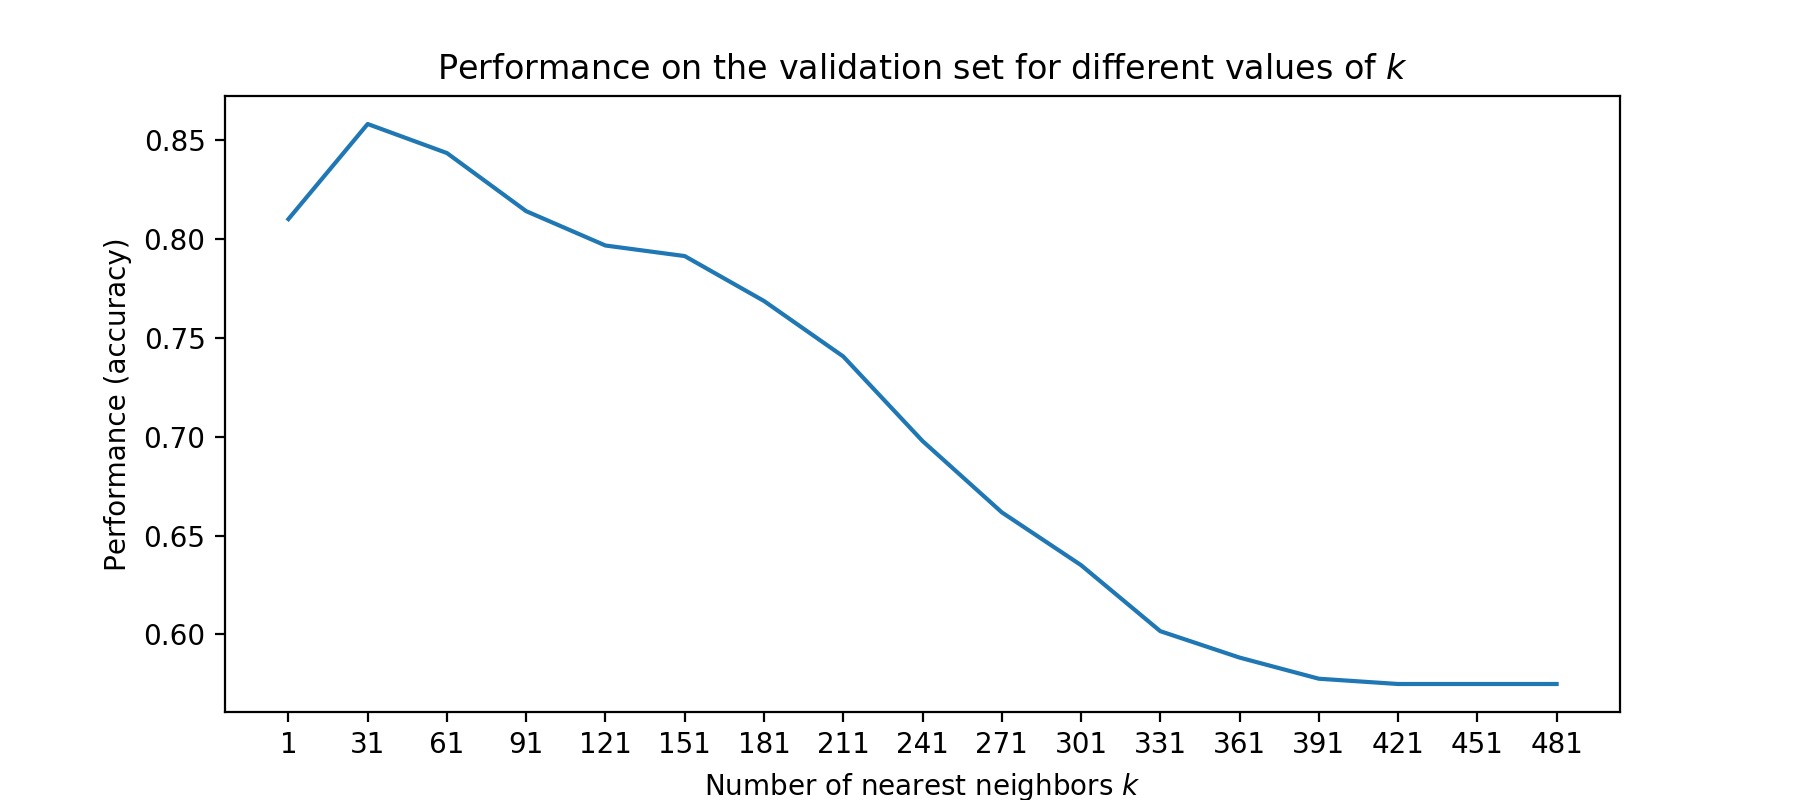

In [32]:
# Visualize the performances for different values of k

k_values = range(1, 500, 30)          # Try these values for hyperparameter k
k_fold = 4
model_performance= run_cv_for_hyperparam(k_values,k_fold,norm_train_features,training_labels)

plt.figure(figsize=(9,4))
plt.title("Performance on the validation set for different values of $k$")
plt.plot(k_values, model_performance)
plt.xlabel("Number of nearest neighbors $k$")
plt.xticks(k_values)
plt.ylabel("Performance (accuracy)");
    

### 5.6 Does your final model generalize to Unseen test data?

Now that we have tuned our model, we can apply it for prediction on the test set using the optimal $k$ found on cross-validations set.

**Q. How do you expect the model to perform, compared with the cross-validation set performance?**

**A.** If our validation set at every fold level is representative of the underlying distribution, we can expect accurate predictions. How accurate they are will depend on the problem. Usually due to sampling bias in the training and validation sets, we can expect slightly lower results on the test set.

In [33]:
# get the labels on the test-set using the best k value after CV
# WRITE YOUR CODE HERE
predicted_test_labels = kNN(norm_test_features, norm_train_features, training_labels, best_k)

<IPython.core.display.Javascript object>


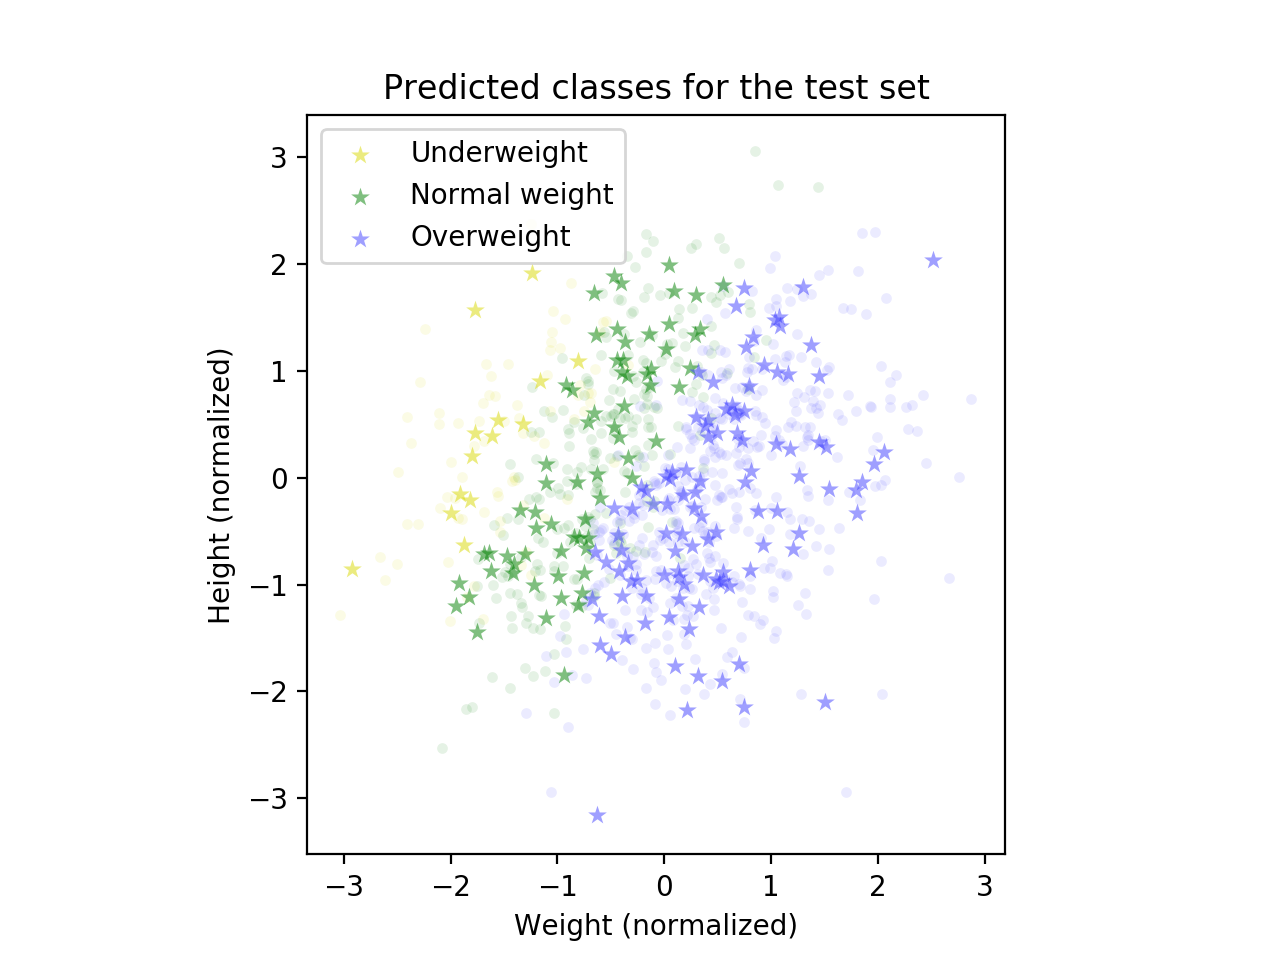

In [34]:
# Visualize the predictions on the test set

plt.figure()
plt.title("Predicted classes for the test set")
for i, class_name in enumerate(class_names):
    plt.scatter(*norm_train_features[training_labels==i].T,
                c=colors[i, None], alpha=0.1, s=15, lw=0)
for i, class_name in enumerate(class_names):    
    plt.scatter(*norm_test_features[predicted_test_labels==i].T,
                c=colors[i, None], marker='*', alpha=0.5, s=50, lw=0, label=class_name)
plt.gca().set_aspect('equal')
plt.xlabel("Weight (normalized)")
plt.ylabel("Height (normalized)")
plt.legend();

In [138]:
performance = accuracy(test_labels, predicted_test_labels)
print(f"{best_k}-NN Classifier predicted correctly {performance:.2%} of the test examples.")

23-NN Classifier predicted correctly 86.70% of the test examples.


**Q. Was this the value you were expecting?**

**A.** The predictions visually seem consistent with what one would expect. Since the metric used here is not ideal for multiclass classification, it should not be alarming that the value is lower than the one obtained from the validation set.

## 6. Predicting on unannotated data

We are finally ready to apply our model for prediction on unannotated data.

In [35]:
# Data loading and preparation for unannotated data
features_unannotated = np.load(features_unannotated_path)
# WRITE YOUR CODE HERE
norm_features_unannotated = normalize(features_unannotated, mean_features, std_features)


**Q. What should one take into account when feeding new data to a machine learning model?**

**A.** Same distribution assumption. This in practice also means that any transformation we applied on the training data, such as the data normalization operation that we applied above, should be applied in the same way to all the rest of the data.

In [36]:
# Get predicted labeles for unannotated data.
# WRITE YOUR CODE HERE
predicted_labels_unannotated = kNN(norm_features_unannotated, norm_train_features, training_labels, best_k)

<IPython.core.display.Javascript object>


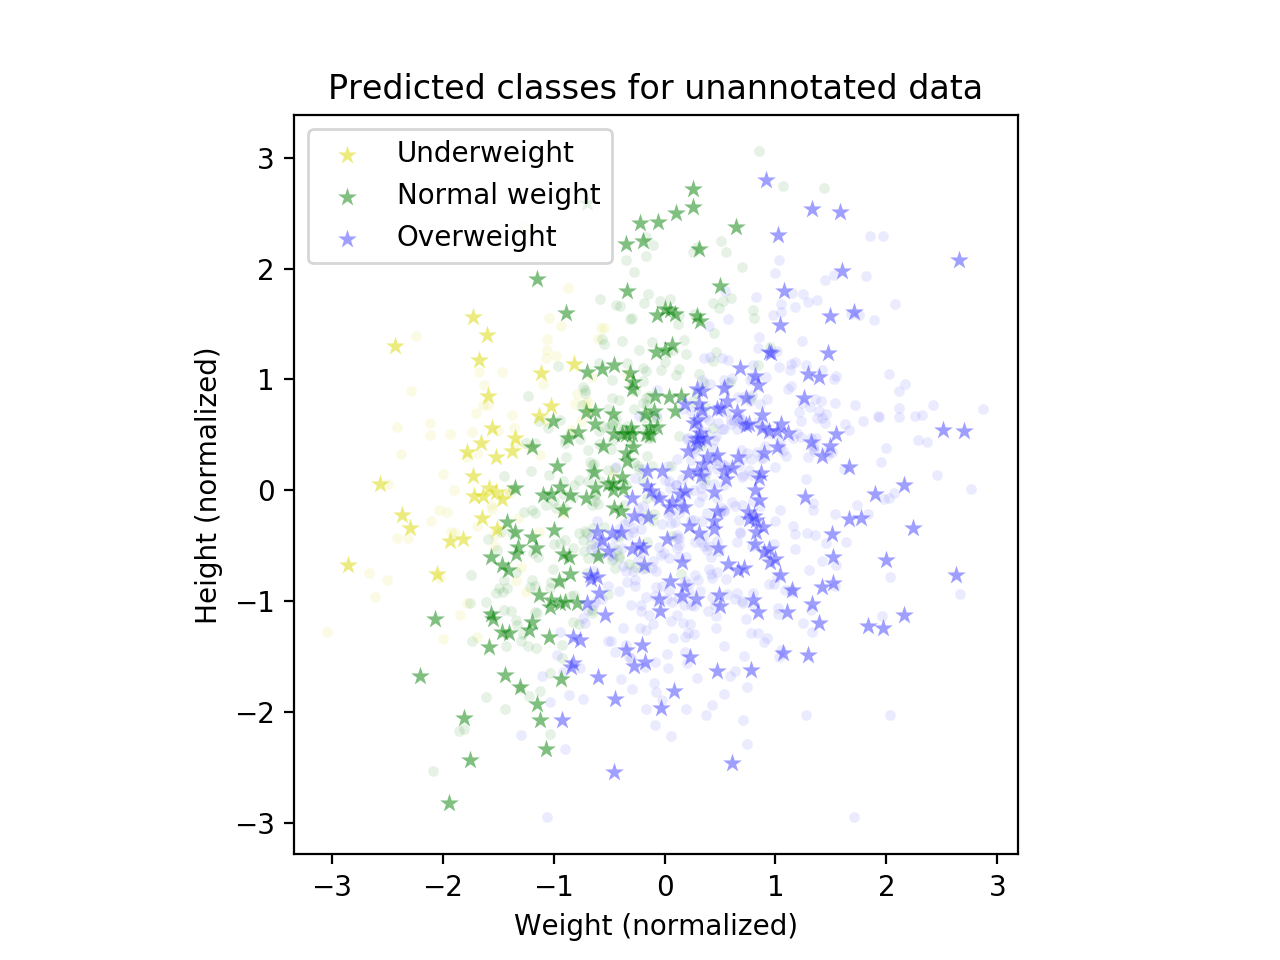

In [37]:
# Visualize the predictions on the unannoated set

plt.figure()
plt.title("Predicted classes for unannotated data")
for i, class_name in enumerate(class_names):
    plt.scatter(*norm_train_features[training_labels==i].T,
                c=colors[i, None], alpha=0.1, s=15, lw=0)
for i, class_name in enumerate(class_names):    
    plt.scatter(*norm_features_unannotated[predicted_labels_unannotated==i].T,
                c=colors[i, None], marker='*', alpha=0.5, s=50, lw=0, label=class_name)
plt.gca().set_aspect('equal')
plt.xlabel("Weight (normalized)")
plt.ylabel("Height (normalized)")
plt.legend();

**Q. Do these class assignments look reasonable to you?**  
**A.** Yes. The predictions are (mostly) correct.


**Q. How would you evaluate if your predictions are reasonable here, without labels?**  
**A.** One idea could be to compare the predicted class frequencies with the class frequencies of the training data.